In [2]:
import pandas as pd
import numpy as np
import os,re,random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

### Pre-processing

In [3]:
exp_m = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/exp_profile/LIHC_coding_gene_fpkm.txt",sep='\t',index_col=0)
metadata = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/sample_info/sample_info_df.txt",sep='\t',index_col=0)
vote = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/ensemble_learning_result/ensemble_hbv_only_np_ratio_35_vote_result.txt",sep='\t',index_col=0)
voted_gene = list(set(vote.index[vote['Vote'] > 0]).intersection(exp_m.index))
non_voted_gene = list(set(exp_m.index) - set(voted_gene))

In [4]:
hallmark_gene_df = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/hallmark_gene/hallmark_protein_coding_ens_id.txt",sep='\t')
hallmark_gene = hallmark_gene_df['EnsID'].values

In [5]:
samples = metadata['Sample'][np.where((metadata['Label'] == 'Tumor'),True,False)]
target_m = exp_m.loc[:,samples]
metadata = metadata.loc[np.where((metadata['Label'] == 'Tumor'),True,False),:]
y = np.where(metadata['HBV'] =='Positive',1,0)
scaler = StandardScaler()
std_x = scaler.fit_transform(target_m.T.to_numpy())
std_m = pd.DataFrame(std_x,index=target_m.columns,columns = target_m.index).T

### HBV prediction by random sampling non-voted genes

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA

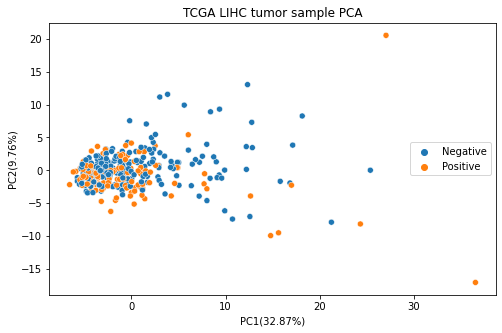

In [185]:
voted_m = std_m.loc[hallmark_gene,:].T.to_numpy()
pca = PCA(n_components=2)
pca_res = pca.fit_transform(voted_m)
pca_df = pd.DataFrame(pca_res,columns=['PC1','PC2'])
pca_df['HBV'] = ["Positive" if x == 1 else "Negative" for x in y]
plt.figure(figsize=(8,5))
sns.scatterplot(data=pca_df,x='PC1',y='PC2',hue='HBV')
plt.xlabel("PC1({:.2f}%)".format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel("PC2({:.2f}%)".format(100 * pca.explained_variance_ratio_[1]))
plt.title("TCGA LIHC tumor sample PCA")
plt.legend(loc='center right')
plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/tcga_hbv_prediction/hallmark_genes_tcga_lihc_pca.svg",format='svg',dpi=300)

In [69]:
def random_sampling_prediction(exp_matrix,y,gene_list,n_target,classifier,metrices = ['accuracy',"f1","precision","recall"],n_iter = 100) :
    metric_df = pd.DataFrame(np.zeros([n_iter,len(metrices)],dtype=np.float16),columns = metrices)
    for n in range(n_iter) :
        if n % 10 == 9 :
            print("Number of %d iterations of CV" % n+1)
        target_gene = random.sample(gene_list,n_target)
        target_x = exp_matrix.loc[target_gene,:].T.to_numpy()
        cv_res = cross_validate(classifier,target_x,y,cv=10,scoring=metrices)
        for idx,metric in enumerate(metrices) :
            metric_df.iloc[n,idx] = cv_res["test_" + metric].mean()
    return metric_df

In [ ]:
clf_dict = {'SVM' : SVC(kernel='linear'),
            'Logistic regression' : LogisticRegression(),
            'Random forest' : RandomForestClassifier()}
plot_df = pd.DataFrame()
for clf_name, clf in clf_dict.items() :
    df = random_sampling_prediction(std_m,y,non_voted_gene,1410,clf)
    cv_res = df.melt()
    cv_res['Classifier'] = [clf_name] * cv_res.shape[0]
    plot_df = pd.concat([plot_df,cv_res])
plot_df.to_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/tcga_hbv_prediction/random_sampling_non_voted_genes_hbv_prediction.txt",sep='\t')

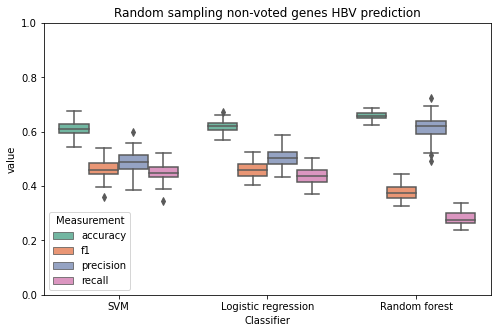

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(data = plot_df,x='Classifier',y = 'value',hue='variable',palette='Set2')
plt.ylim([0,1])
plt.legend(title='Measurement',loc='lower left')
plt.title("Random sampling non-voted genes HBV prediction")
plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/tcga_hbv_prediction/random_sampling_non_voted_genes_hbv_prediction.svg",format='svg',dpi=300)

In [6]:
clf_dict = {'SVM' : SVC(kernel='linear'),
            'Logistic regression' : LogisticRegression(),
            'Random forest' : RandomForestClassifier()}
metrices = ['accuracy',"f1","precision","recall"]
metric_df = pd.DataFrame(np.empty([3,4]),index = list(clf_dict.keys()),columns = metrices)
target_x = std_m.loc[voted_gene,:].T.to_numpy()

for clf_name, clf in clf_dict.items() :
    cv_res = cross_validate(clf,target_x,y,cv=10,scoring=metrices)
    for idx,metric in enumerate(metrices) :
        metric_df.loc[clf_name,metric] = "%0.4f (%0.2f)" % (cv_res["test_" + metric].mean(),cv_res["test_" + metric].std())

/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
plot_df = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/tcga_hbv_prediction/random_sampling_non_voted_genes_hbv_prediction.txt",sep='\t',index_col=0)

In [24]:
metric_quntile_df = metric_df.copy()
for clf in metric_df.index :
    for m in metric_df.columns :
        voted_gene_val = np.float16(metric_df.loc[clf,m].split(' ')[0])
        idx = np.where((plot_df['variable'] == m) & (plot_df['Classifier'] == clf),True,False)
        values = plot_df.loc[idx,'value']
        n = sum(np.where(values < voted_gene_val,True,False) )
        metric_quntile_df.loc[clf,m] = str(n) + "%"

In [26]:
metric_quntile_df.to_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/tcga_hbv_prediction/voted_genes_hbv_prediction_quntile.txt",sep='\t')

### HBV prediction by L1 selected voted genes

In [6]:
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
selected_m = np.zeros([10,11],dtype=int)
for c_idx,c in enumerate(np.arange(0.3,0.4,0.01)) :
    for idx in range(10) :
        clf = LogisticRegression(penalty = 'l1',C = c,solver='saga',max_iter=1000,n_jobs=32)
        x = std_m.loc[voted_gene,:].T.to_numpy()
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,stratify=y)
        clf.fit(X_train,y_train)
        n_features = sum(clf.coef_[0,:] > 0)
        print("Number of features remained : %s at l1 lambda : %0.2f" % (n_features,c))
        selected_m[idx,c_idx] = n_features

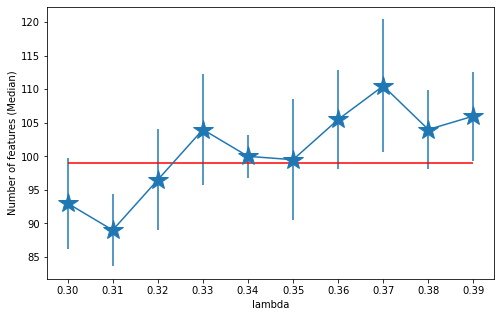

In [176]:
df = pd.DataFrame(selected_m,columns = ["c_" + str(round(x,2)) for x in np.arange(0.3,0.39,0.01)])
n_mean = df.median()
n_std = df.std()
c = np.arange(0.3,0.39,0.01)
plt.figure(figsize=(8,5))
plt.errorbar(c, n_mean, n_std, marker='*', ms=20)
plt.hlines(99,0.3,0.39,color='r')
plt.xticks(c)
plt.xlabel("lambda")
plt.ylabel("Number of features (Median)")
plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/tcga_hbv_prediction/n_voted_genes_l1_selected.svg",format='svg',dpi=300)

In [ ]:
acc_m = np.zeros([10,21],dtype=np.float16)
for c_idx,c in enumerate(np.arange(0.6,0.8,0.01)) :
    for idx in range(10) :
        clf = LogisticRegression(penalty = 'l2',C = c,solver='saga',max_iter=10000,n_jobs=32)
        x = std_m.loc[hallmark_gene,:].T.to_numpy()
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,stratify=y)
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_pred,y_test)
        print("Accuracy : %0.2f at l2 lambda : %0.2f" % (acc,c))
        acc_m[idx,c_idx] = acc

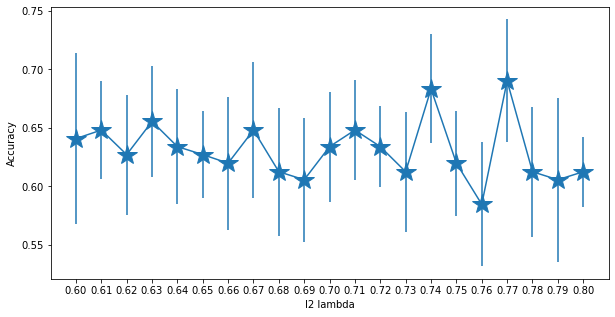

In [44]:
df = pd.DataFrame(acc_m[:,:],columns = ["c_" + str(round(x,2)) for x in np.arange(0.6,0.8,0.01)])
n_mean = df.median()
n_std = df.std()
c = np.arange(0.6,0.8,0.01)
plt.figure(figsize=(10,5))
plt.errorbar(c, n_mean, n_std, marker='*', ms=20)
#plt.hlines(99,0.3,0.39,color='r')
plt.xticks(c)
plt.xlabel("l2 lambda")
plt.ylabel("Accuracy")
plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/tcga_hbv_prediction/hallmark_genes_l2_selected.svg",format='svg',dpi=300)

In [45]:
metrices = ['accuracy',"f1","precision","recall"]
l1_clf = LogisticRegression(penalty = 'l1',C = 0.35,solver='saga',max_iter=10000,n_jobs=32)
x = std_m.loc[voted_gene,:].T.to_numpy()
cv_res = cross_validate(l1_clf,x,y,cv=10,scoring=metrices)

l1_clf = LogisticRegression(penalty = 'l2',C = 0.77,solver='saga',max_iter=10000,n_jobs=32)
x = std_m.loc[hallmark_gene,:].T.to_numpy()
hallmark_cv_res = cross_validate(l1_clf,x,y,cv=10,scoring=metrices)

In [49]:
hallmark_cv_df = pd.DataFrame(np.zeros([10,4],dtype=np.float16),columns=metrices)
l1_cv_df = pd.DataFrame(np.zeros([10,4],dtype=np.float16),columns=metrices)
for metric in metrices :
    hallmark_cv_df[metric] = hallmark_cv_res["test_"+metric]
    l1_cv_df[metric] = cv_res["test_"+metric]
hallmark_melt = hallmark_cv_df.melt()
hallmark_melt['Group'] = ['Hallmark'] * hallmark_melt.shape[0]
l1_melt = l1_cv_df.melt()
l1_melt['Group'] = ['L1 selected'] * hallmark_melt.shape[0]
plot_df = pd.concat([hallmark_melt,l1_melt])

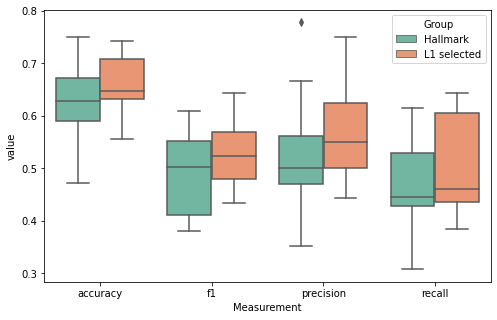

In [54]:
plt.figure(figsize=(8,5))
sns.boxplot(data=plot_df,x='variable',y='value',hue='Group',palette='Set2')
plt.xlabel("Measurement")
plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/tcga_hbv_prediction/hallmark_genes_vs_l1_selected_gene.svg",format='svg',dpi=300)

### module gene HBV prediction

In [1]:
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

In [6]:
def edge2node(edge_context) :
    '''
    edge_list : str, like 'ENSG00000115415 ENSG00000138496_ENSG00000115415 ENSG00000168961_ENSG00000115415, underline as seperator
    '''
    edge_l = edge_context.split('_')
    node_l = set(list(map(lambda x : x.split(' ')[0],edge_l)) + list(map(lambda x : x.split(' ')[1],edge_l)))
    return list(node_l)

In [10]:
ppi = 'GRN'
module_excel = pd.ExcelFile("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/functional_module_summary/Summary_table_of_%s_FunModu.xlsx" % ppi)
module_info = pd.read_excel(module_excel,sheet_name='hbv_only_35')

In [11]:
clf_metric = {'LogisticRegression' : pd.DataFrame(),'SVM' : pd.DataFrame(),'RandomForest' : pd.DataFrame()}
clf_dict = {'LogisticRegression' : LogisticRegression(max_iter=2000),'SVM' : SVC(),'RandomForest' : RandomForestClassifier()}
metrices = ['accuracy',"f1","precision","recall"]

for i in range(module_info.shape[0]) :
    for clf_name,clf in clf_dict.items() :
        module_metric_m = pd.DataFrame(np.zeros([10,4],dtype=np.float16),columns=metrices)
        gene_list = edge2node(module_info['Edges'][i])
        module_name = module_info['Description'][i]
        module_exp = std_m.loc[gene_list,:].T.to_numpy()
        cv_res = cross_validate(clf,module_exp,y,cv=10,scoring=metrices)
        for idx,metric in enumerate(metrices) :
            module_metric_m.iloc[:,idx] = cv_res["test_" + metric]
        module_metric_m['Module'] = [module_name] *  module_metric_m.shape[0]   
        clf_metric[clf_name] = pd.concat([clf_metric[clf_name],module_metric_m])
    

/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification

In [ ]:
for clf_name,lr_cv in clf_metric.items() :
    plot_df = lr_cv.melt(id_vars='Module')
    plot_df.columns = ['Module','Measurement','value']
    plt.figure(figsize=(10,10))
    plt.rcParams["font.family"] = ["Nimbus Roman"]
    sns.boxplot(data=plot_df,x='value',y='Module',hue='Measurement',palette='Set3')
    plt.title("%s module gene %s 10-fold CV HBV prediction" % (ppi,clf_name),fontsize=17)
    plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/module_gene_hbv_prediction/%s_%s_10fold_cv_hbv_prediction.png" % (ppi,clf_name),dpi=300,bbox_inches='tight')